In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.formula.api as smf
import pickle
import statsmodels.stats.multitest
from pymer4.models import Lmer # requires R + packages `lme4` and `lmerTest` (R version used here: 4.2.2)

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)

from utils import transform, plot, stats

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 16, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"

/data/project/ei_development/env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# Figure 6. Optimal model parameters inter-relation and association with age in the PNC dataset

Load optimal simulations, demographics and other data needed:

In [3]:
parcels = transform.load_ordered_parcel_labels('schaefer-100')
elig_subs = pd.read_csv(
    os.path.join(INPUT_DIR, "pnc_subs.csv"), index_col=0
).sort_index()

if os.path.exists('pnc_optima.csv') & os.path.exists('pnc_vars.pkz'):
    subjects_optima = pd.read_csv('pnc_optima.csv', index_col=0)
    with open('pnc_vars.pkz', 'rb') as f:
        regional_vars = pickle.load(f)
else:
    raise FileNotFoundError("Run Figure 2 first")

best_runs = subjects_optima.groupby("sub")["gof"].idxmax().values
data = subjects_optima.loc[best_runs].set_index("sub")
data[["age", "sex"]] = elig_subs.loc[data.index, ["age", "sex"]]
data["Age (y)"] = data["age"] / 12

# add motion data
motion = pd.read_csv(
    os.path.join(OUTPUT_DIR["pnc"], 'postfmriprep', 'participants.tsv'), 
    delimiter="\t", index_col=0
).loc[data.index]
data = pd.concat([data, motion], axis=1)

In [4]:
# aggregate subject parameters into dataframes
param_dfs = {}

for param in ['w_EE', 'w_EI', 'w_IE']:
    param_dfs[param] = pd.DataFrame(index=data.index, columns=parcels, dtype=float)
    for i, parc in enumerate(parcels):
        for sub, row in data.iterrows():
            param_dfs[param].loc[sub, parc] = regional_vars[sub][row["SeedMW"]].loc[i, param]

In [5]:
# calculate mean parameters
for param in ['w_EE', 'w_EI', 'w_IE']:
    data.loc[:, f'mean_{param}'] = param_dfs[param].mean(axis=1)

## a. Inter-relation of parameters

### left: Correlation of G and mean regional parameters

In [6]:
mean_params = ['G', 'mean_w_EE', 'mean_w_EI', 'mean_w_IE']
mean_r = pd.DataFrame(index=mean_params, columns=mean_params, dtype=float)
mean_p = pd.DataFrame(index=mean_params, columns=mean_params, dtype=float)
for i, param_i in enumerate(mean_params):
    for j, param_j in enumerate(mean_params):
        if i > j:
            mean_r.loc[param_i, param_j] = scipy.stats.pearsonr(data[param_i], data[param_j]).statistic
            mean_p.loc[param_i, param_j] = scipy.stats.pearsonr(data[param_i], data[param_j]).pvalue
mean_r = mean_r.dropna(0, 'all').dropna(1, 'all')
mean_p = mean_p.dropna(0, 'all').dropna(1, 'all')
alpha = 0.05 / 6 # bonferroni
mean_sig = mean_p < alpha

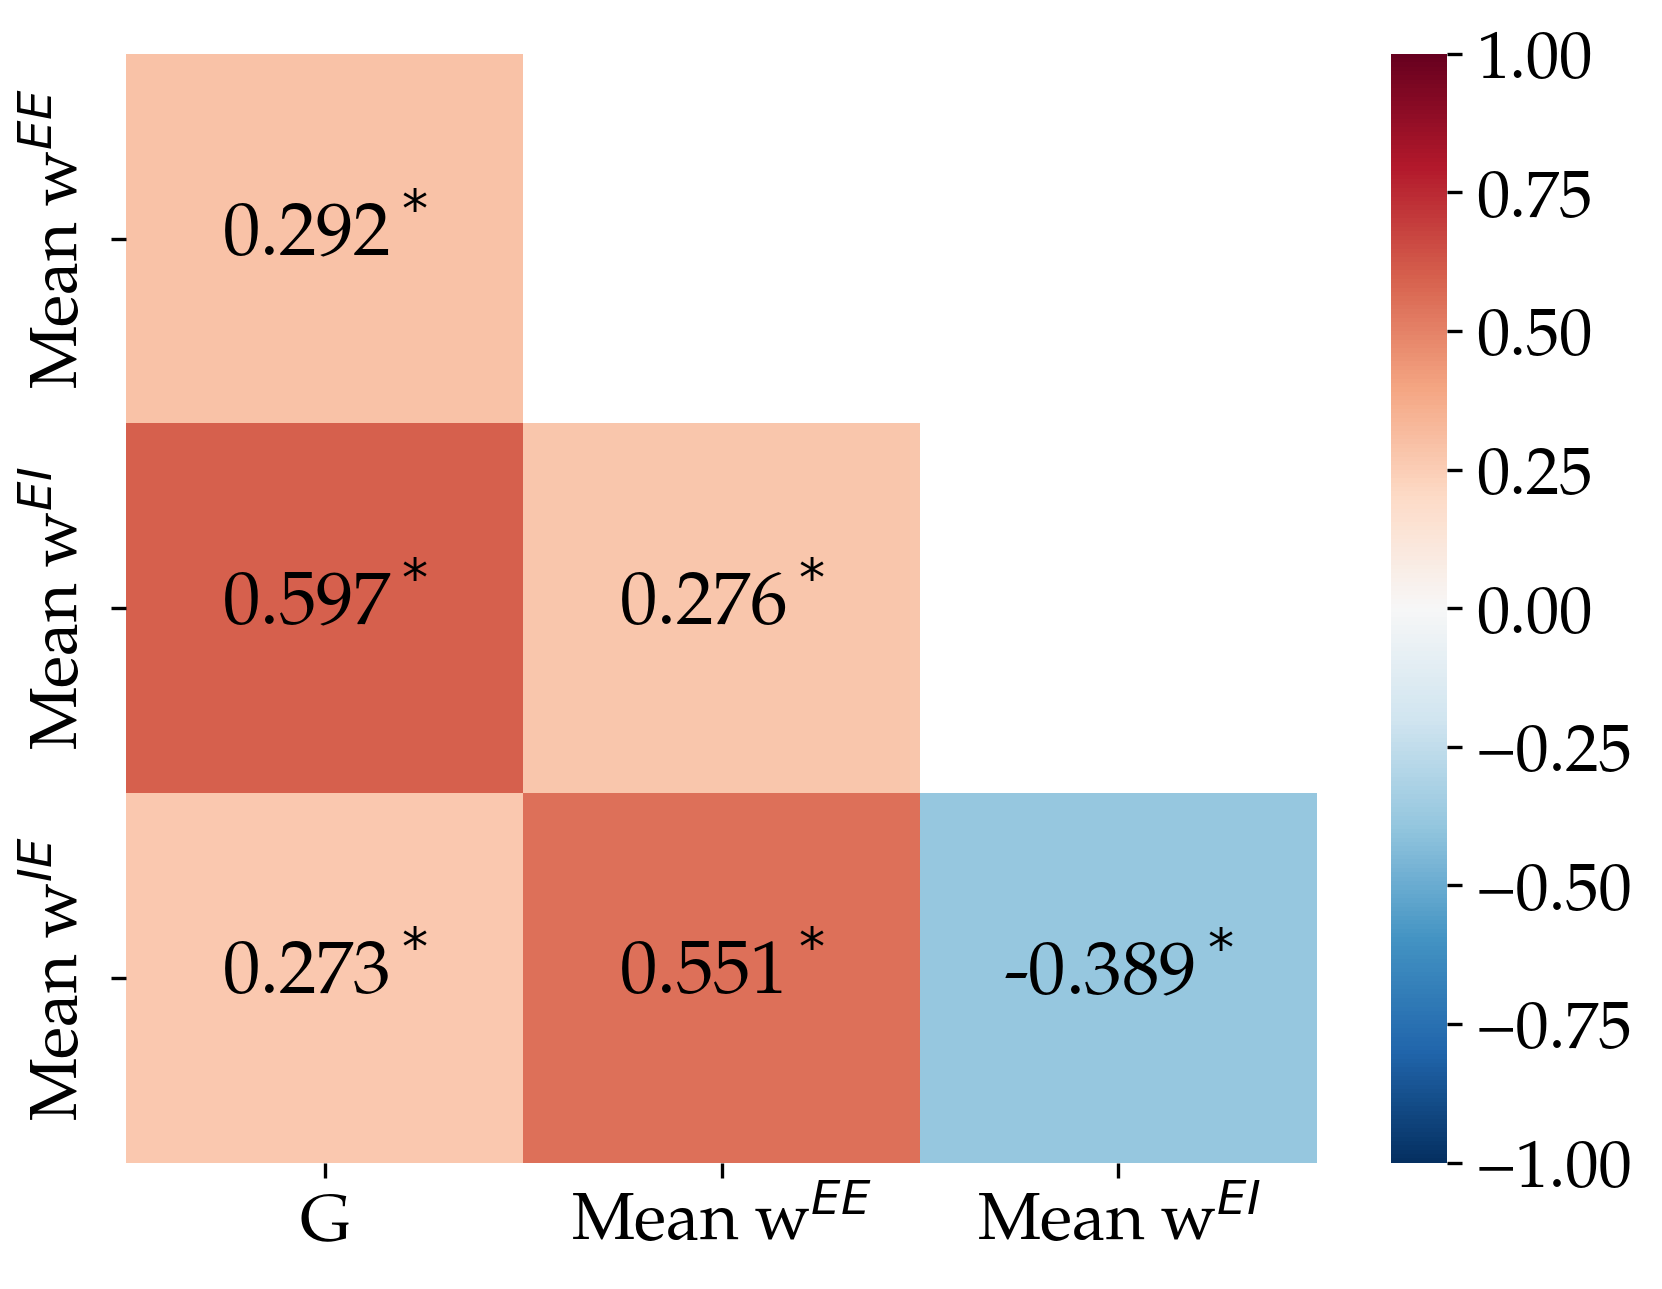

In [7]:
ax = sns.heatmap(mean_r.dropna(0, 'all').dropna(1, 'all'), cmap='RdBu_r', vmin=-1, vmax=1)
for x, col in enumerate(mean_r.columns):
    for y, row in enumerate(mean_r.index):
        if y >= x:
            text = f'{mean_r.loc[row, col]:.3f}'
            if mean_sig.loc[row, col]:
                text += r'$^*$'
            ax.text(x+0.5, y+0.5, 
                    text, 
                    fontsize=18,
                    horizontalalignment='center', 
                    verticalalignment='center')
ax.set_xticklabels(['G', r'Mean w$^{EE}$', r'Mean w$^{EI}$'])
ax.set_yticklabels([r'Mean w$^{EE}$', r'Mean w$^{EI}$', r'Mean w$^{IE}$']);

### right: Association of regional parameters across nodes and subjects

In [8]:
clean_names = {
    'G': 'G',
    'w_EE': r'$w^{EE}$',
    'w_EI': r'$w^{EI}$',
    'w_IE': r'$w^{IE}$',
}

long_df = pd.concat([param_dfs['w_EE'].unstack().reset_index(), 
                     param_dfs['w_EI'].unstack().reset_index(drop=True),
                     param_dfs['w_IE'].unstack().reset_index(drop=True)], 
                    axis=1)

long_df.columns = ['node', 'sub', 'w_EE', 'w_EI', 'w_IE']

#### $w^{EE}$ ~ $w^{EI}$

In [9]:
curr_p1 = 'w_EE'
curr_p2 = 'w_EI'
model = Lmer(f"{curr_p1} ~ {curr_p2} + (1 + {curr_p2} | node)", data=long_df)
print(model.fit())

r2 = 1 - (((model.residuals)**2).sum()) / (((long_df[curr_p1]-long_df[curr_p1].mean())**2).sum())
print("R2", r2)

Linear mixed model fit by REML [’lmerMod’]
Formula: w_EE~w_EI+(1+w_EI|node)

Family: gaussian	 Inference: parametric

Number of observations: 75200	 Groups: {'node': 100.0}

Log-likelihood: 51079.499 	 AIC: -102146.998

Random effects:

                 Name    Var    Std
node      (Intercept)  0.001  0.027
node             w_EI  0.002  0.049
Residual               0.015  0.122

              IV1   IV2   Corr
node  (Intercept)  w_EI -0.751

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     0.125   0.119    0.130  0.003  100.238  42.897    0.0  ***
w_EI            0.098   0.088    0.108  0.005   96.368  19.079    0.0  ***
R2 0.0757900210315916


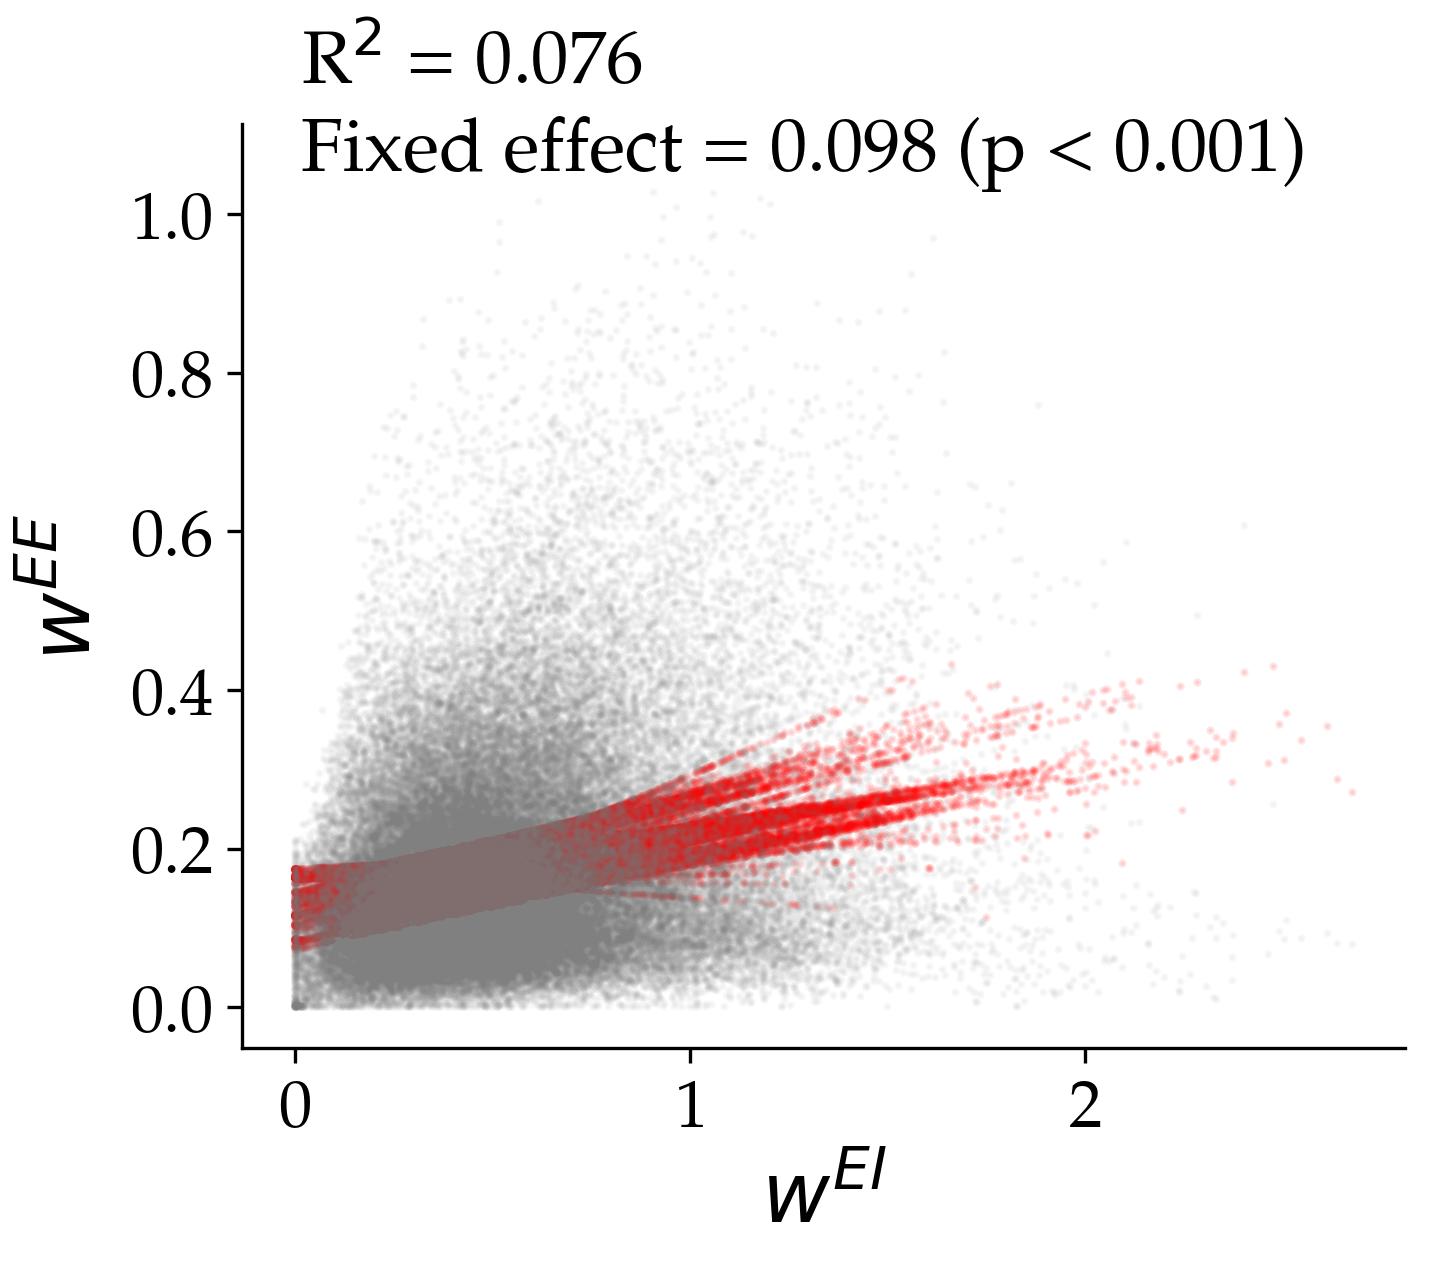

In [10]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(long_df[curr_p2], long_df[curr_p1]-model.residuals, s=1, color='red', alpha=0.1)
ax.scatter(long_df[curr_p2], long_df[curr_p1], s=1, color='grey', alpha=0.05)
ax.set_xlabel(clean_names[curr_p2], fontsize=20)
ax.set_ylabel(clean_names[curr_p1], fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
coef = model.coefs.loc[curr_p2, 'Estimate']
p = model.coefs.loc[curr_p2, 'P-val']
text = r'R$^2$ = 'f'{r2:.3f}\nFixed effect = {coef:.3f} ('
if p < 0.001:
    text += 'p < 0.001)'
else:
    text += f'p = {p:.3f})'
ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
sns.despine()

#### $w^{EE}$ ~ $w^{IE}$

In [11]:
curr_p1 = 'w_EE'
curr_p2 = 'w_IE'
model = Lmer(f"{curr_p1} ~ {curr_p2} + (1 + {curr_p2} | node)", data=long_df)
print(model.fit())

r2 = 1 - (((model.residuals)**2).sum()) / (((long_df[curr_p1]-long_df[curr_p1].mean())**2).sum())
print("R2", r2)

Linear mixed model fit by REML [’lmerMod’]
Formula: w_EE~w_IE+(1+w_IE|node)

Family: gaussian	 Inference: parametric

Number of observations: 75200	 Groups: {'node': 100.0}

Log-likelihood: 51508.022 	 AIC: -103004.044

Random effects:

                 Name    Var    Std
node      (Intercept)  0.003  0.057
node             w_IE  0.001  0.037
Residual               0.015  0.121

              IV1   IV2  Corr
node  (Intercept)  w_IE -0.91

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)     0.100   0.089    0.112  0.006  98.505  17.161    0.0  ***
w_IE            0.049   0.042    0.057  0.004  96.861  13.079    0.0  ***
R2 0.088206099142631


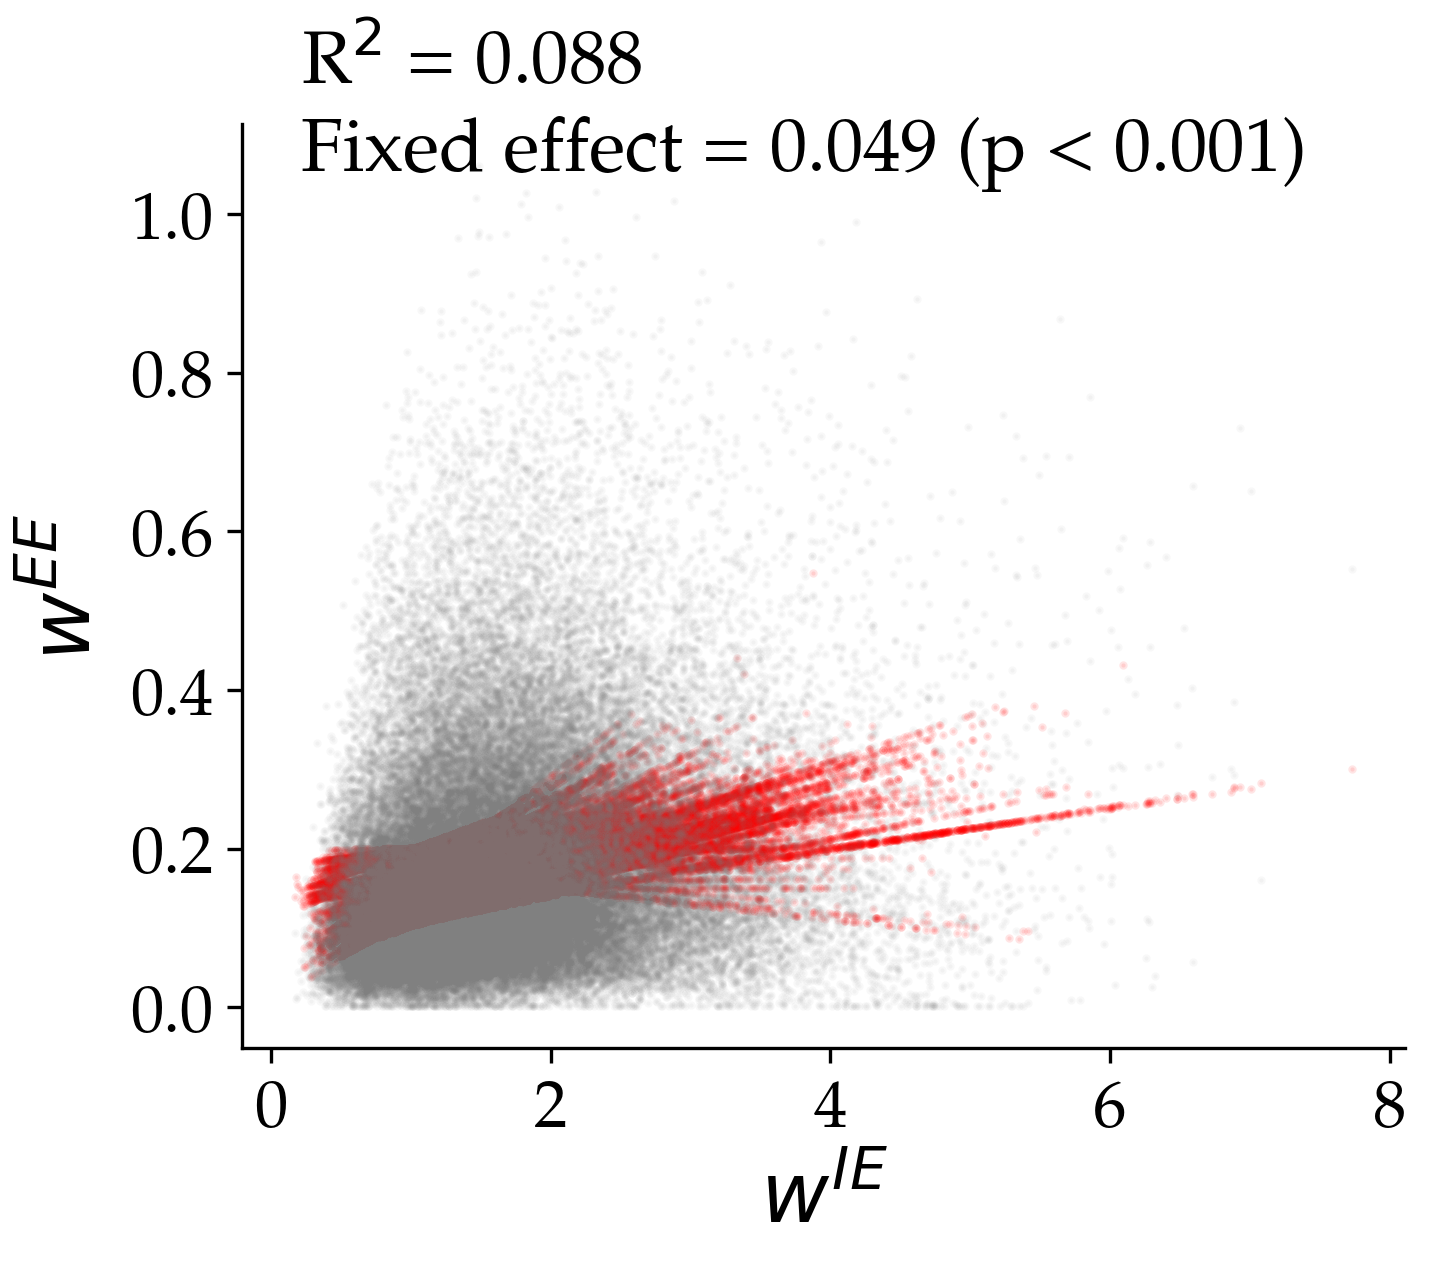

In [12]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(long_df[curr_p2], long_df[curr_p1]-model.residuals, s=1, color='red', alpha=0.1)
ax.scatter(long_df[curr_p2], long_df[curr_p1], s=1, color='grey', alpha=0.05)
ax.set_xlabel(clean_names[curr_p2], fontsize=20)
ax.set_ylabel(clean_names[curr_p1], fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
coef = model.coefs.loc[curr_p2, 'Estimate']
p = model.coefs.loc[curr_p2, 'P-val']
text = r'R$^2$ = 'f'{r2:.3f}\nFixed effect = {coef:.3f} ('
if p < 0.001:
    text += 'p < 0.001)'
else:
    text += f'p = {p:.3f})'
ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
sns.despine()

#### $w^{EI}$ ~ $w^{IE}$

In [13]:
curr_p1 = 'w_EI'
curr_p2 = 'w_IE'
model = Lmer(f"{curr_p1} ~ {curr_p2} + (1 + {curr_p2} | node)", data=long_df)
print(model.fit())

r2 = 1 - (((model.residuals)**2).sum()) / (((long_df[curr_p1]-long_df[curr_p1].mean())**2).sum())
print("R2", r2)

Linear mixed model fit by REML [’lmerMod’]
Formula: w_EI~w_IE+(1+w_IE|node)

Family: gaussian	 Inference: parametric

Number of observations: 75200	 Groups: {'node': 100.0}

Log-likelihood: 12561.548 	 AIC: -25111.095

Random effects:

                 Name    Var    Std
node      (Intercept)  0.044  0.209
node             w_IE  0.015  0.123
Residual               0.041  0.203

              IV1   IV2   Corr
node  (Intercept)  w_IE -0.829

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)     1.050   1.009    1.091  0.021  99.234  49.927    0.0  ***
w_IE           -0.325  -0.349   -0.301  0.012  98.421 -26.272    0.0  ***
R2 0.5757542223677331


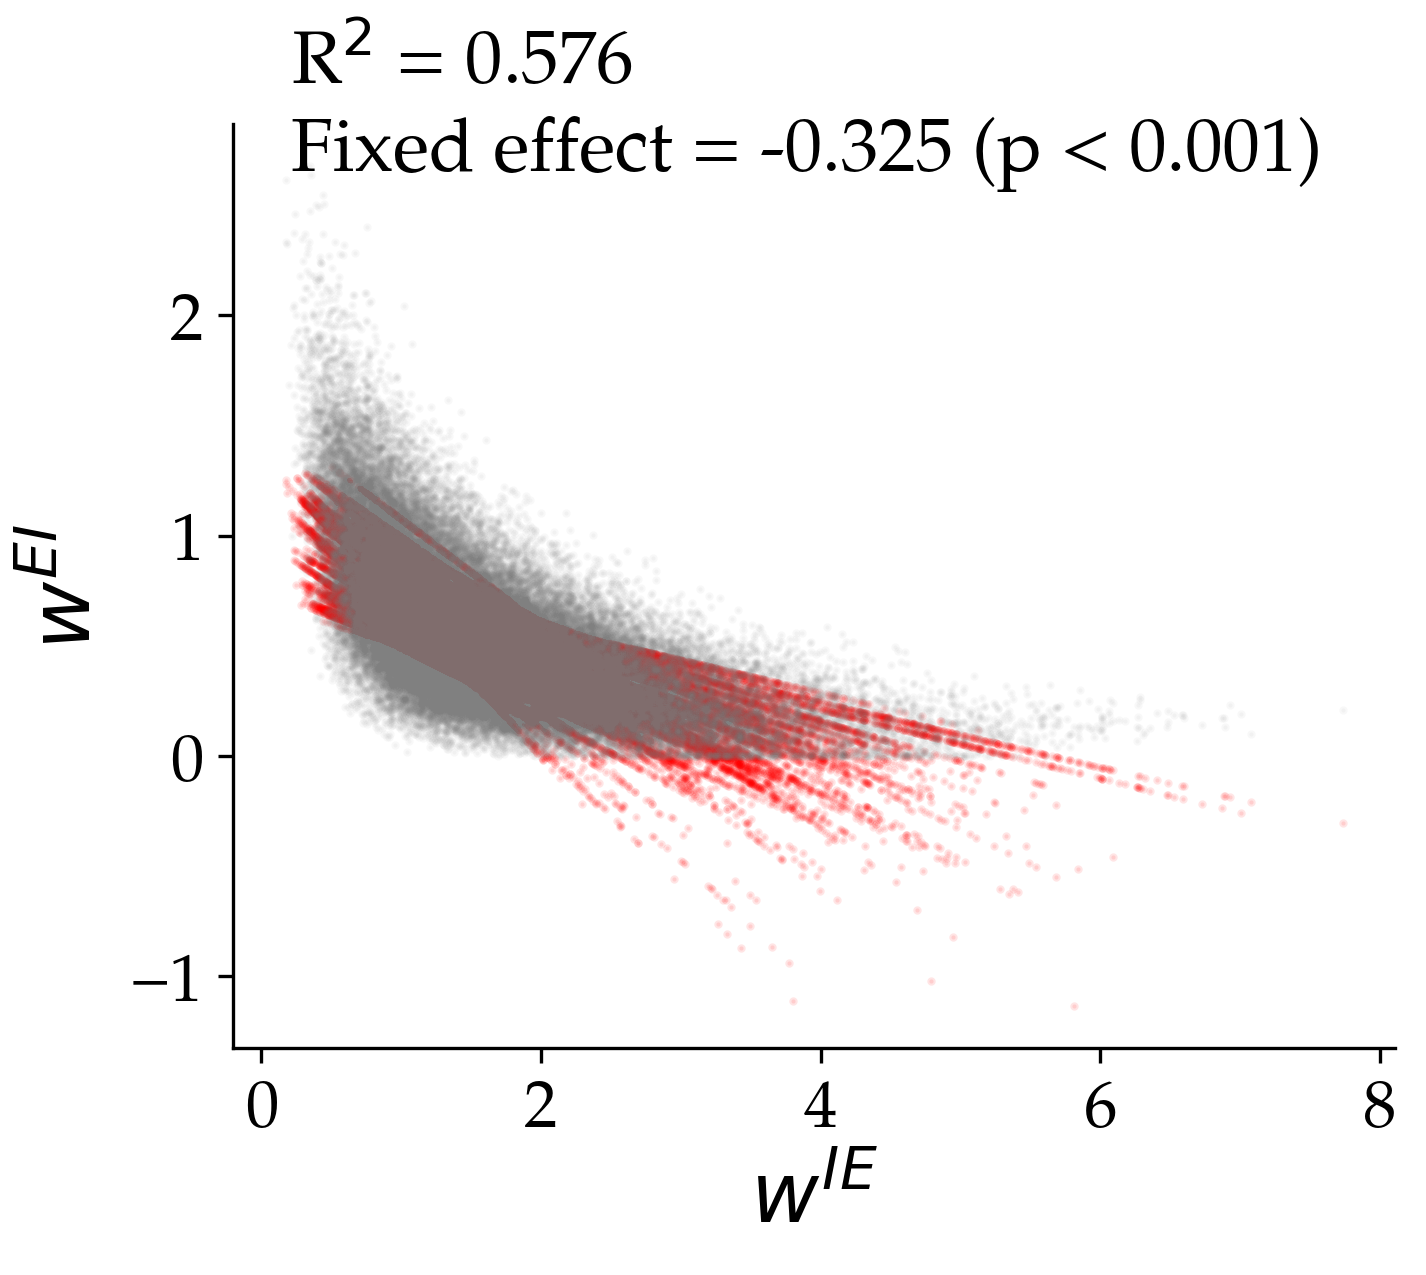

In [14]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(long_df[curr_p2], long_df[curr_p1]-model.residuals, s=1, color='red', alpha=0.1)
ax.scatter(long_df[curr_p2], long_df[curr_p1], s=1, color='grey', alpha=0.05)
ax.set_xlabel(clean_names[curr_p2], fontsize=20)
ax.set_ylabel(clean_names[curr_p1], fontsize=20)
text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
coef = model.coefs.loc[curr_p2, 'Estimate']
p = model.coefs.loc[curr_p2, 'P-val']
text = r'R$^2$ = 'f'{r2:.3f}\nFixed effect = {coef:.3f} ('
if p < 0.001:
    text += 'p < 0.001)'
else:
    text += f'p = {p:.3f})'
ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
sns.despine()

## b. Effect of age on optimal parameters

### $G$

In [15]:
# exclude outliers
curr_subs = data.index[(scipy.stats.zscore(data.loc[:, "G"]).abs() < 3)]
model_df = data.loc[curr_subs]
# fit the confound removal model to calculate pearson's r of the
# residual of I_E with age as an easy-to-interpret effect size
res_conf = smf.ols("G ~ gof + sex + mean_rms", data=model_df).fit()
model_df["resid"] = res_conf.resid
r_age = scipy.stats.pearsonr(model_df["age"], model_df["resid"]).statistic
# fit the main model
mod = smf.ols("G ~ age + gof + sex + mean_rms", data=model_df)
res = mod.fit()
print("Pearson's r", r_age)
print(res.summary())

Pearson's r -0.08454931702088742
                            OLS Regression Results                            
Dep. Variable:                      G   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     27.13
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           4.86e-21
Time:                        15:41:07   Log-Likelihood:                -615.79
No. Observations:                 751   AIC:                             1242.
Df Residuals:                     746   BIC:                             1265.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.16

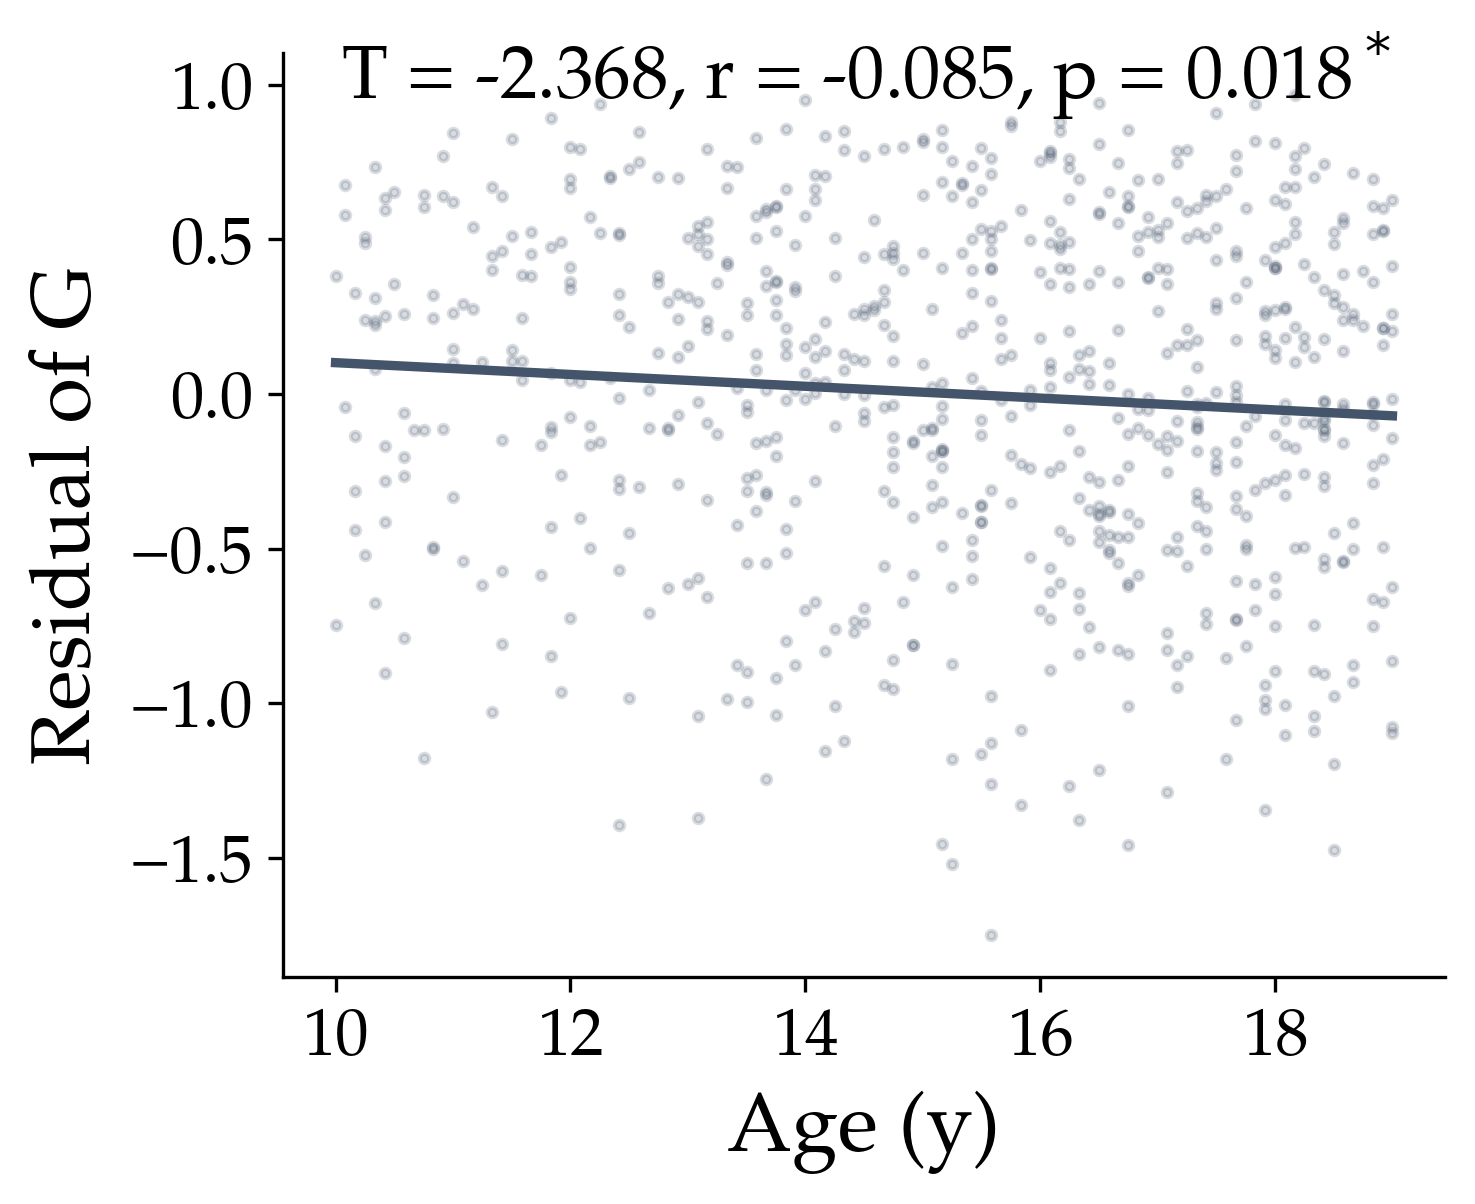

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))
add_text = True

sns.regplot(
    x=model_df["Age (y)"],
    y=model_df["resid"],
    ax=ax,
    ci=None,
    scatter_kws=dict(color=thcolor, alpha=0.2, s=5),
    line_kws=dict(color=thcolor, alpha=1.0),
)
p = res.pvalues["age"]
t = res.tvalues["age"]
if add_text:
    text = f"T = {t:.3f}, r = {r_age:.3f}"
    if p > 0.001:
        text += f", p = {p:.3f}"
    else:
        text += ", p < 0.001"
    if p < 0.05:
        text += r"$^*$"
    text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
    text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
    ax.text(text_x, text_y, text, color="black", size=18, multialignment="left")
ax.set_ylabel(r"Residual of G", fontsize=20)
ax.set_xlabel("Age (y)", fontsize=20)
sns.despine()

### $w^{EE}$

In [17]:
stats_age = {}

In [18]:
curr_p = 'w_EE'
df = pd.concat([param_dfs[curr_p], data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = param_dfs[curr_p].index[(scipy.stats.zscore(param_dfs[curr_p].loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age[curr_p] = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[curr_p].to_csv(f"p_pnc_fc-sub_sc-sub_runs-2_{curr_p}_age_stats.csv")
stats_age[curr_p][stats_age[curr_p]["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr
7Networks_RH_DorsAttn_FEF_1,-3.925,-0.140,0.000,0.009
7Networks_LH_DorsAttn_FEF_1,-3.558,-0.127,0.000,0.015
7Networks_LH_DorsAttn_Post_4,-3.360,-0.120,0.001,0.015
7Networks_LH_SomMot_6,-3.335,-0.120,0.001,0.015
7Networks_RH_Vis_3,-3.309,-0.119,0.001,0.015
7Networks_RH_SalVentAttn_Med_1,-3.271,-0.117,0.001,0.015
7Networks_RH_SomMot_4,-3.229,-0.116,0.001,0.015
7Networks_LH_SalVentAttn_Med_2,-3.220,-0.115,0.001,0.015
7Networks_RH_SalVentAttn_Med_2,-3.195,-0.114,0.001,0.015
7Networks_RH_SomMot_7,-3.193,-0.114,0.001,0.015


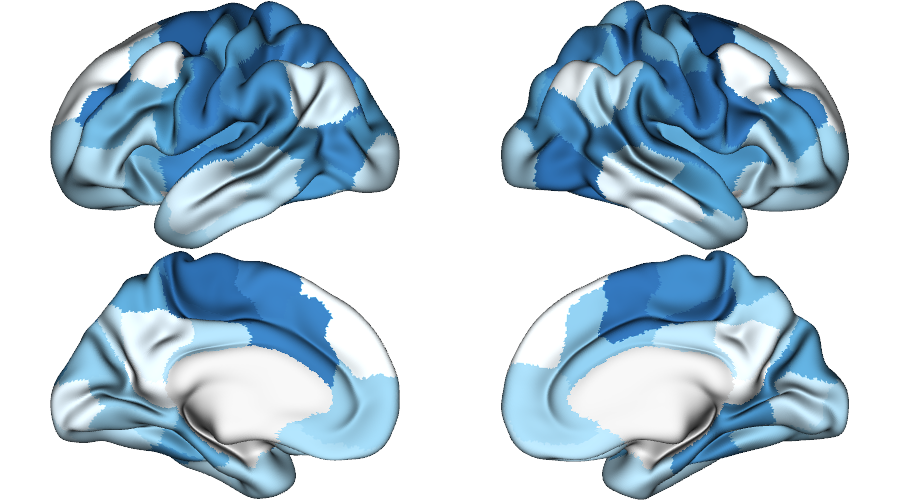

In [19]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

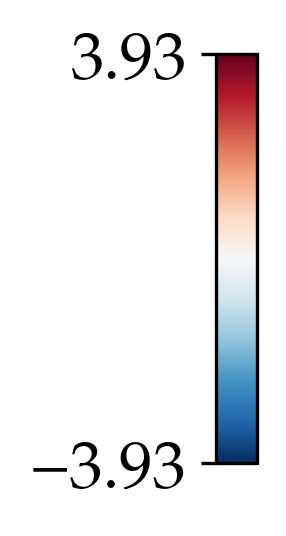

In [20]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

### $w^{EI}$

In [21]:
curr_p = 'w_EI'
df = pd.concat([param_dfs[curr_p], data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = param_dfs[curr_p].index[(scipy.stats.zscore(param_dfs[curr_p].loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age[curr_p] = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[curr_p].to_csv(f"p_pnc_fc-sub_sc-sub_runs-2_{curr_p}_age_stats.csv")
stats_age[curr_p][stats_age[curr_p]["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr
7Networks_LH_Vis_7,-7.857,-0.273,0.000,0.000
7Networks_RH_Vis_7,-7.520,-0.262,0.000,0.000
7Networks_RH_Vis_3,-7.486,-0.261,0.000,0.000
7Networks_RH_Vis_1,-6.610,-0.231,0.000,0.000
7Networks_RH_SalVentAttn_TempOccPar_1,-6.508,-0.228,0.000,0.000
...,...,...,...,...
7Networks_LH_Default_PFC_7,-2.301,-0.082,0.022,0.026
7Networks_RH_Default_PFCdPFCm_3,-2.252,-0.081,0.025,0.030
7Networks_RH_Default_Par_1,-2.122,-0.076,0.034,0.041
7Networks_RH_Default_pCunPCC_2,-2.072,-0.074,0.039,0.045


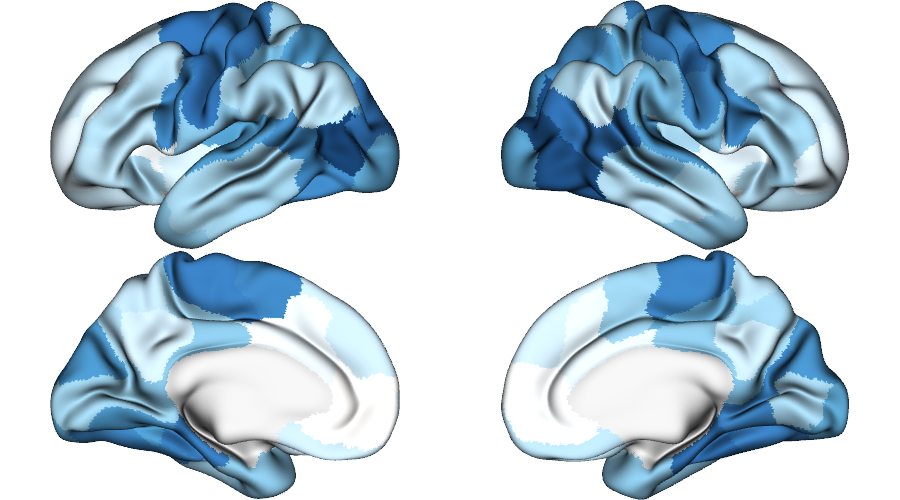

In [22]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

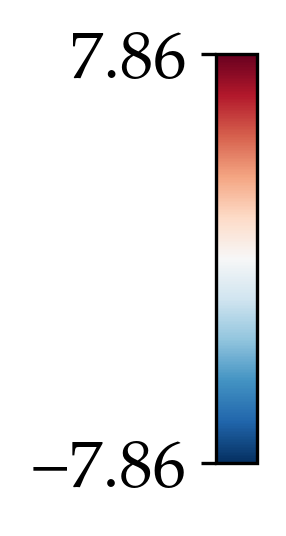

In [23]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

### $w^{IE}$

In [24]:
curr_p = 'w_IE'
df = pd.concat([param_dfs[curr_p], data], axis=1)
df.columns = [f"node_{i}" for i in range(100)] + list(df.columns[100:])

t_age = pd.Series(index=parcels)
r_age = pd.Series(index=parcels)
p_age = pd.Series(index=parcels)
for i, parc in enumerate(parcels):
    # exclude outliers
    curr_subs = param_dfs[curr_p].index[(scipy.stats.zscore(param_dfs[curr_p].loc[:, parc]).abs() < 3)]
    model_df = df.loc[curr_subs]
    # fit the confound removal model to calculate pearson's r of the
    # residual of I_E with age as an easy-to-interpret effect size
    res_conf = smf.ols(f"node_{i} ~ gof + sex + mean_rms", data=model_df).fit()
    r_age.loc[parc] = scipy.stats.pearsonr(model_df["age"], res_conf.resid).statistic
    # fit the main model
    mod = smf.ols(f"node_{i} ~ age + gof + sex + mean_rms", data=model_df)
    res = mod.fit()
    t_age.loc[parc] = res.tvalues["age"]
    p_age.loc[parc] = res.pvalues["age"]

# FDR correction
_, p_age_fdr = statsmodels.stats.multitest.fdrcorrection(p_age)
p_age_fdr = pd.Series(p_age_fdr, index=parcels)

# display stats of signficant regions
stats_age[curr_p] = pd.DataFrame({"t": t_age, "r": r_age, "p": p_age, "p_fdr": p_age_fdr})
stats_age[curr_p].to_csv(f"p_pnc_fc-sub_sc-sub_runs-2_{curr_p}_age_stats.csv")
stats_age[curr_p][stats_age[curr_p]["p_fdr"] < 0.05].sort_values(by="t").round(3)

,t,r,p,p_fdr
7Networks_RH_Default_Temp_2,2.197,0.079,0.028,0.050
7Networks_LH_Limbic_TempPole_1,2.211,0.079,0.027,0.049
7Networks_RH_Cont_PFCl_4,2.479,0.089,0.013,0.024
7Networks_RH_Cont_Par_2,2.527,0.091,0.012,0.022
7Networks_LH_Default_PFC_6,2.633,0.095,0.009,0.016
7Networks_RH_Default_pCunPCC_1,2.645,0.095,0.008,0.016
7Networks_RH_DorsAttn_FEF_1,2.652,0.095,0.008,0.016
7Networks_LH_SalVentAttn_ParOper_1,2.673,0.096,0.008,0.015
7Networks_LH_Default_PFC_1,2.684,0.096,0.007,0.015
7Networks_RH_DorsAttn_Post_1,2.701,0.097,0.007,0.015


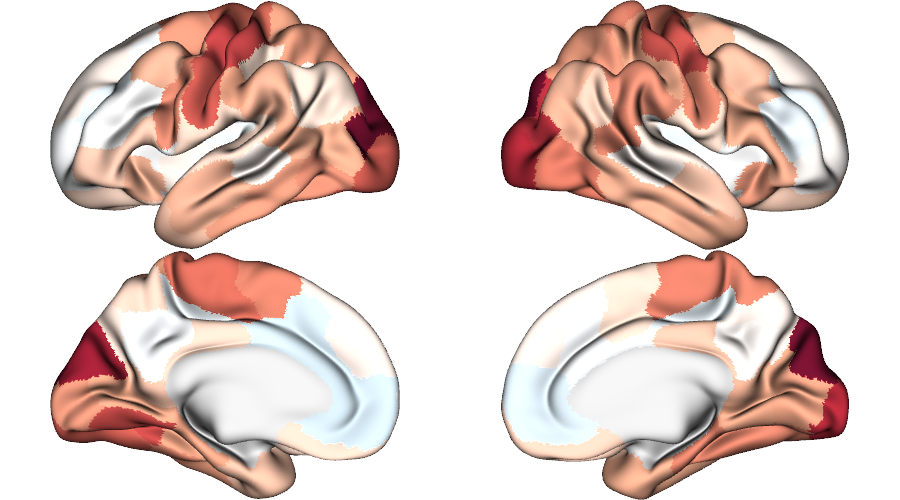

In [25]:
plot.plot_surface(
    transform.deparcellate_surf(t_age, "schaefer-100", concat=True, space="fsaverage"),
    "fsaverage",
    mesh_kind="semi-inflated",
    vrange="sym",
    cmap="RdBu_r",
    cbar=False,
    layout_style="grid",
)

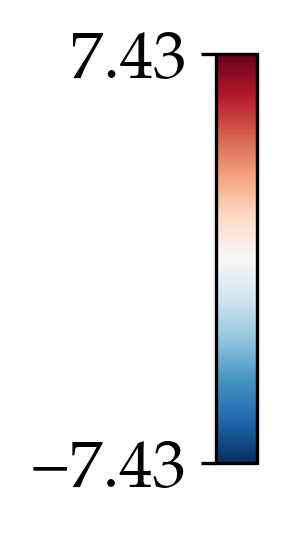

In [26]:
vmin = min(t_age.values.min(), -t_age.values.max())
vmax = -vmin
plot.plot_colorbar(vmin.round(2), vmax.round(2), "RdBu_r", figsize=(2, 2));

## Text. Cross-correlation of parameter age effects

In [27]:
t_ages = pd.DataFrame({k: v['t'] for k, v in stats_age.items()})
r, p, _ = stats.spin_test_parcellated(t_ages, t_ages, 'schaefer-100', n_perm=1000)
print(r.round(3))
print(p.round(3))

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
       w_EE   w_EI   w_IE
w_EE  1.000  0.450 -0.078
w_EI  0.450  1.000 -0.706
w_IE -0.078 -0.706  1.000
       w_EE  w_EI   w_IE
w_EE  0.000   0.0  0.428
w_EI  0.000   0.0  0.000
w_IE  0.483   0.0  0.000
